# CoexpressDeconvolve

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl

import time
a = time.time()

In [2]:
def ReadVisium(path):
    from scipy.io import mmread
    Barcodes = pd.read_csv(f"{path}/filtered_feature_bc_matrix/barcodes.tsv.gz", header=None,
                           low_memory=False,
                           sep='\t')
    Barcodes = Barcodes.iloc[:, 0]
    Features = pd.read_csv(f"{path}/filtered_feature_bc_matrix/features.tsv.gz", header=None,
                           low_memory=False,
                           sep='\t')
    Features = Features.iloc[:, 1]
    Matrix = mmread(f"{path}/filtered_feature_bc_matrix/matrix.mtx.gz")
    from scipy import sparse
    Matrix = Matrix.transpose()
    Visium = pd.DataFrame.sparse.from_spmatrix(Matrix, columns=Features)
    Visium.set_index(Barcodes, inplace=True)
    Visium.index.names = ['Barcodes']
    return Visium

def ReadPositionsVisiumSD(path):
    Positions = pd.read_csv(f"{path}/spatial/tissue_positions.csv")
    Positions.set_index("barcode", inplace = True)
    Positions.index.names = ['Barcodes']
    return Positions

def DeconvolveCellTypes(Visium, df_clusters):

    cluster_sums = []

    for idx, gene_list in df_clusters.iloc[:, 0].items():
        # Filter for genes present in the expression data
        valid_genes = [gene for gene in gene_list if gene in Visium.index]
        # Sum expression values for these genes
        cluster_sum = Visium.loc[valid_genes].sum(axis=0)
        # Append result as a new row
        cluster_sums.append(cluster_sum)

    # Convert to DataFrame
    cluster_sum_df = pd.DataFrame(cluster_sums, index=df_clusters.index, columns=Visium.columns)
    return cluster_sum_df

def fit_negative_binomial(data):
    mean_val = np.mean(data)
    var_val = np.var(data)
    
    if var_val > mean_val: 
        r_est = mean_val ** 2 / (var_val - mean_val) 
        p_est = mean_val / var_val  
    else:
        r_est, p_est = np.nan, np.nan 
    
    return r_est, p_est

def VisiumUMISumPerGene(path):
    Features = pd.read_csv(f"{path}/filtered_feature_bc_matrix/features.tsv.gz", header=None,
                           low_memory=False,
                           sep='\t')
    Features = Features.iloc[:, 1]
    from scipy.io import mmread
    Matrix = mmread(f"{path}/filtered_feature_bc_matrix/matrix.mtx.gz")
    from scipy.sparse import csr_matrix
    sdf = csr_matrix(Matrix, dtype='int8')
    UMI_sum = pd.DataFrame(sdf.sum(axis=1))
    UMI_sum.set_index(Features, inplace=True)
    UMI_sum.index.names = ['Features']
    UMI_sum.rename(columns={0:'Feature Counts in Spots Under Tissue'}, inplace=True)
    return UMI_sum

In [3]:
tissue_positions_data = ReadPositionsVisiumSD(".")

# Rotate Image
# Swap x and y
# tissue_positions_data = tissue_positions_data.rename(columns={'pxl_row_in_fullres': 'pxl_col_in_fullres', 'pxl_col_in_fullres': 'pxl_row_in_fullres'})

# 1st mirror
# tissue_positions_data['pxl_col_in_fullres'] = -(tissue_positions_data['pxl_col_in_fullres']-tissue_positions_data['pxl_col_in_fullres'].max()) 
# 2nd mirror
# tissue_positions_data['pxl_row_in_fullres'] = -(tissue_positions_data['pxl_row_in_fullres']-tissue_positions_data['pxl_row_in_fullres'].max()) 
tissue_positions_data.head()

,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres
Barcodes,,,,,
GTCACTTCCTTCTAGA-1,0,0,0,773.128258,255.644541
CACGGTCTCCTTACGA-1,0,0,2,773.146401,277.022931
ATAGCTGCGGATAAGA-1,0,0,4,773.164545,298.401321
GTCAGTATGTCCGGCG-1,1,0,6,773.182688,319.779712
ATGTACCAGTTACTCG-1,0,0,8,773.200831,341.158102


In [4]:
Visium = ReadVisium(".")
Visium.rename_axis("Gene", axis=1,inplace=True)
Visium = Visium.T
Visium

Barcodes,AACAGGAAGAGCATAG-1,AACAGGATTCATAGTT-1,AACAGGTTCACCGAAG-1,AACAGTCAGGCTCCGC-1,AACATACTCATATGCG-1,AACATAGTCTATCTAC-1,AACATGCGCAAGTGAG-1,AACCAAGGTATCAGGC-1,AACCAATCTGGTTGGC-1,AACCACTAACATGATT-1,...,TGTTCAGAACGGTGTA-1,TGTTCAGCGAGGCAGT-1,TGTTCATAGTATGACG-1,TGTTCATTGGTCCAAG-1,TGTTCCTCACATTAAT-1,TGTTGGAACCTTCCGC-1,TGTTGGAACGAGGTCA-1,TGTTGGAAGCTCGGTA-1,TGTTGGATGGACTTCT-1,TGTTGGCCAGACCTAC-1
Gene,,,,,,,,,,,,,,,,,,,,,
Xkr4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rp1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sox17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lypla1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tcea1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zfy2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sry,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm4064,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Make sure to trim the genes with the low expression! This usually results in the 8-10K genes retained

Metrics = VisiumUMISumPerGene('.')

Metrics = Metrics[~Metrics.index.str.startswith((
                                                 'MT-', 
                                                 # 'LINC',
                                                 # 'MIR', 
                                                 'RP'
))]
Metrics.drop(Metrics[Metrics['Feature Counts in Spots Under Tissue'] < 1000].index, inplace=True)
# Metrics.drop(Metrics[Metrics['Feature Counts in Spots Under Tissue'] > 50000].index, inplace=True)

Metrics

,Feature Counts in Spots Under Tissue
Features,
Lmbrd1,1246
Zfp451,1727
Cnnm3,3181
Pou3f3,2908
Klf7,1189
...,...
Mecp2,1100
Fam50a,2103
Cstf2,1036


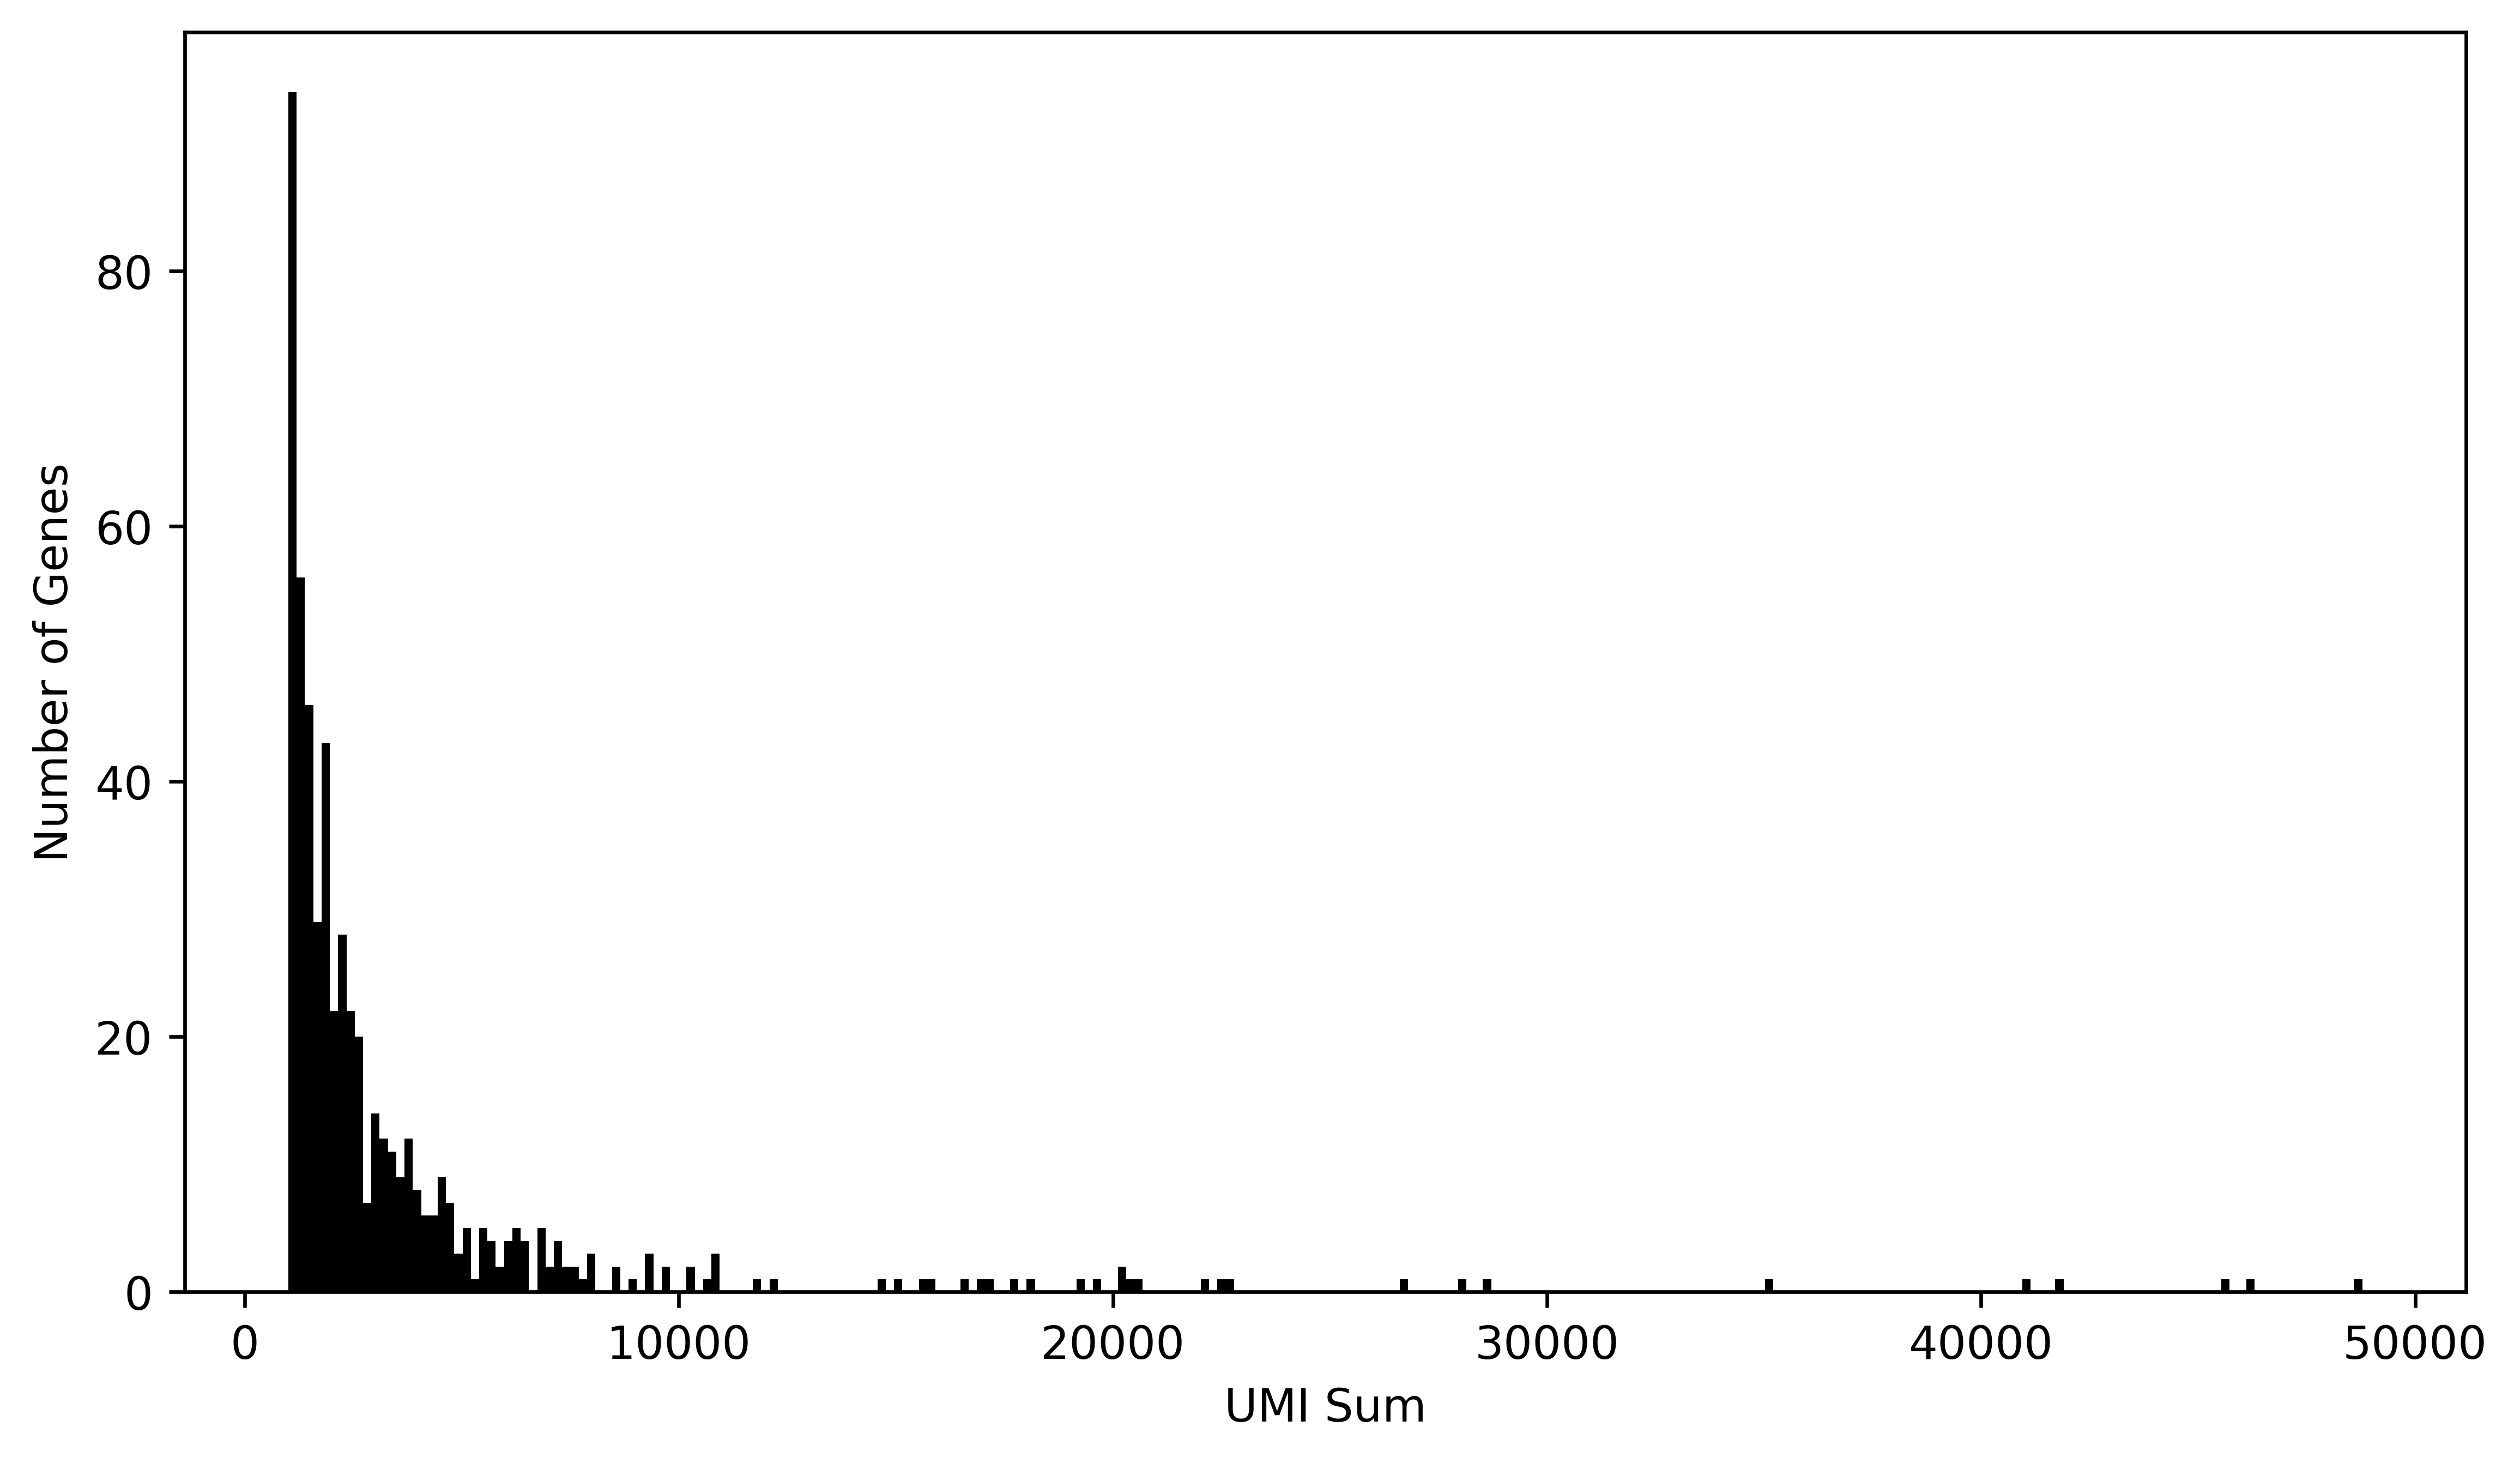

In [6]:
plt.figure(figsize=(9,5), dpi=600)
n_bins = 250
plt.hist(Metrics['Feature Counts in Spots Under Tissue'], n_bins, color='black')
plt.xlabel('UMI Sum')
plt.ylabel('Number of Genes')
plt.show()

In [7]:
# Replace non 0 with 1 to get rid of the GEX levels
Visium_Corr = Visium.where(Visium == 0, 1)
# Visium_Corr = Visium
Visium_Corr = Visium_Corr[Visium_Corr.index.isin(Metrics.index)]
Visium_Corr = Visium_Corr.T
Visium_Corr.head()

Gene,Lmbrd1,Zfp451,Cnnm3,Pou3f3,Klf7,Igfbp5,Tns1,Cab39,Stk25,Zcchc2,...,Wbp1l,Nanos1,Pcsk1n,Elk1,Pgrmc1,Mecp2,Fam50a,Cstf2,Tspyl2,Tmsb4x
Barcodes,,,,,,,,,,,,,,,,,,,,,
AACAGGAAGAGCATAG-1,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
AACAGGATTCATAGTT-1,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,1,0,0,0
AACAGGTTCACCGAAG-1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
AACAGTCAGGCTCCGC-1,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AACATACTCATATGCG-1,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Perform gene corr analysis

corr_df = Visium_Corr
corr_df.rename_axis("Gene", inplace=True)
corr_df.rename_axis("Gene", axis=1,inplace=True)

correlation_matrix = corr_df.corr(method='pearson') # pearson / spearman 

correlation_matrix

Gene,Lmbrd1,Zfp451,Cnnm3,Pou3f3,Klf7,Igfbp5,Tns1,Cab39,Stk25,Zcchc2,...,Wbp1l,Nanos1,Pcsk1n,Elk1,Pgrmc1,Mecp2,Fam50a,Cstf2,Tspyl2,Tmsb4x
Gene,,,,,,,,,,,,,,,,,,,,,
Lmbrd1,1.000000,0.472915,0.430182,0.521364,0.471435,0.208009,0.416899,0.502707,0.460226,0.348497,...,0.470129,0.479714,0.528547,0.482017,0.487088,0.477044,0.522231,0.461884,0.505425,0.413612
Zfp451,0.472915,1.000000,0.459833,0.536073,0.485757,0.244914,0.421742,0.519478,0.473974,0.409543,...,0.502492,0.548990,0.544962,0.517666,0.513163,0.523780,0.496125,0.475023,0.566343,0.394240
Cnnm3,0.430182,0.459833,1.000000,0.458239,0.426235,0.245155,0.391086,0.473392,0.395043,0.345552,...,0.459015,0.464120,0.475445,0.414578,0.451891,0.443623,0.469234,0.403927,0.469948,0.334129
Pou3f3,0.521364,0.536073,0.458239,1.000000,0.544665,0.256556,0.418594,0.550509,0.523294,0.418111,...,0.491664,0.574544,0.617917,0.569150,0.561951,0.575275,0.511571,0.533029,0.615791,0.442378
Klf7,0.471435,0.485757,0.426235,0.544665,1.000000,0.229400,0.422906,0.499852,0.487433,0.422871,...,0.490592,0.534003,0.592976,0.542053,0.510222,0.549780,0.489129,0.501567,0.562283,0.429181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mecp2,0.477044,0.523780,0.443623,0.575275,0.549780,0.232680,0.424388,0.525724,0.516944,0.404708,...,0.490151,0.538791,0.597124,0.533174,0.542551,1.000000,0.500454,0.543128,0.565085,0.428964
Fam50a,0.522231,0.496125,0.469234,0.511571,0.489129,0.239886,0.439297,0.483180,0.471502,0.359567,...,0.489491,0.503279,0.542160,0.507252,0.513588,0.500454,1.000000,0.474366,0.535932,0.421414
Cstf2,0.461884,0.475023,0.403927,0.533029,0.501567,0.233509,0.388906,0.491988,0.474985,0.376047,...,0.453423,0.485438,0.548820,0.530732,0.504032,0.543128,0.474366,1.000000,0.531431,0.423866


In [9]:
# Choose a threshold (something around 1.5)
threshold = 1.5

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

distance_matrix = 1 - correlation_matrix.abs()

# Perform hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix), method='ward')

clusters = fcluster(linkage_matrix, threshold, criterion='distance')

# Create a dictionary mapping clusters to feature lists
cluster_dict = {}
variables = correlation_matrix.columns

for var, cluster in zip(variables, clusters):
    cluster_dict.setdefault(cluster, []).append(var)

# Remove clusters if needed
filtered_clusters = {k: v for k, v in cluster_dict.items() if len(v) >= 0}

# Convert to DataFrame
df_clusters = pd.DataFrame({'Cluster': list(filtered_clusters.keys()), 'Genes': list(filtered_clusters.values())})
df_clusters.set_index('Cluster', inplace=True)

df_clusters.to_excel('Distance Clusters.xlsx')
df_clusters

,Genes
Cluster,
5,"[Lmbrd1, Pou3f3, Klf7, Stk25, Kif21b, Astn1, R..."
3,"[Zfp451, Cnnm3, Cab39, Zcchc2, Eif2d, Ppfia4, ..."
2,"[Igfbp5, Hnrnpu, Pdia3, Mn1, Hnrnpa2b1, Serbp1..."
4,"[Tns1, Ccdc3, Nes, Bcan, Atp1a1, Plpp3, Mrfap1..."
1,"[Col5a1, Igf2, Palm3, Pxdc1, Clic6]"


In [10]:
Visium = Visium[Visium.index.isin(Metrics.index)]
Visium = Visium[~Visium.index.duplicated(keep="first")]
Visium

Barcodes,AACAGGAAGAGCATAG-1,AACAGGATTCATAGTT-1,AACAGGTTCACCGAAG-1,AACAGTCAGGCTCCGC-1,AACATACTCATATGCG-1,AACATAGTCTATCTAC-1,AACATGCGCAAGTGAG-1,AACCAAGGTATCAGGC-1,AACCAATCTGGTTGGC-1,AACCACTAACATGATT-1,...,TGTTCAGAACGGTGTA-1,TGTTCAGCGAGGCAGT-1,TGTTCATAGTATGACG-1,TGTTCATTGGTCCAAG-1,TGTTCCTCACATTAAT-1,TGTTGGAACCTTCCGC-1,TGTTGGAACGAGGTCA-1,TGTTGGAAGCTCGGTA-1,TGTTGGATGGACTTCT-1,TGTTGGCCAGACCTAC-1
Gene,,,,,,,,,,,,,,,,,,,,,
Lmbrd1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,6
Zfp451,3,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,2
Cnnm3,3,0,0,2,1,0,2,0,2,0,...,1,0,0,0,0,2,4,1,0,6
Pou3f3,0,0,0,0,2,0,3,0,0,0,...,0,0,0,0,0,0,3,0,0,2
Klf7,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,2,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mecp2,1,1,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
Fam50a,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,2,0,0,6
Cstf2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
deconvolution = DeconvolveCellTypes(Visium, df_clusters)
deconvolution

Barcodes,AACAGGAAGAGCATAG-1,AACAGGATTCATAGTT-1,AACAGGTTCACCGAAG-1,AACAGTCAGGCTCCGC-1,AACATACTCATATGCG-1,AACATAGTCTATCTAC-1,AACATGCGCAAGTGAG-1,AACCAAGGTATCAGGC-1,AACCAATCTGGTTGGC-1,AACCACTAACATGATT-1,...,TGTTCAGAACGGTGTA-1,TGTTCAGCGAGGCAGT-1,TGTTCATAGTATGACG-1,TGTTCATTGGTCCAAG-1,TGTTCCTCACATTAAT-1,TGTTGGAACCTTCCGC-1,TGTTGGAACGAGGTCA-1,TGTTGGAAGCTCGGTA-1,TGTTGGATGGACTTCT-1,TGTTGGCCAGACCTAC-1
Cluster,,,,,,,,,,,,,,,,,,,,,
5,44,59,39,14,24,35,171,5,34,27,...,24,52,46,5,9,25,400,18,26,848
3,97,141,75,53,77,128,348,16,142,61,...,75,105,110,25,40,112,912,34,40,1688
2,52,102,21,83,73,165,183,9,165,43,...,47,78,202,20,27,99,457,34,14,974
4,2,20,5,9,5,15,1,2,9,1,...,5,8,47,0,0,7,6,1,1,162
1,2,2,3,0,1,3,0,0,4,1,...,2,0,6,1,3,2,3,0,1,14


In [12]:
df = deconvolution.T

percentile = 0.85 # 0.8 - 0.95 is the recommended range

from scipy.stats import nbinom

# Extract numeric data (excluding Gene column if present)
df_numeric = df.iloc[:, 0:] 

# Fit NB parameters for each feature
nb_params = {col: fit_negative_binomial(df_numeric[col]) for col in df_numeric.columns}
nb_params_df = pd.DataFrame(nb_params, index=["r", "p"]).T

# Compute 90th percentile threshold
thresholds = {col: nbinom.ppf(percentile, nb_params_df.loc[col, "r"], nb_params_df.loc[col, "p"]) 
                 for col in df_numeric.columns}

# Convert to DataFrame
thresholds_df = pd.DataFrame.from_dict(thresholds, orient="index", columns=["UMI Th"])

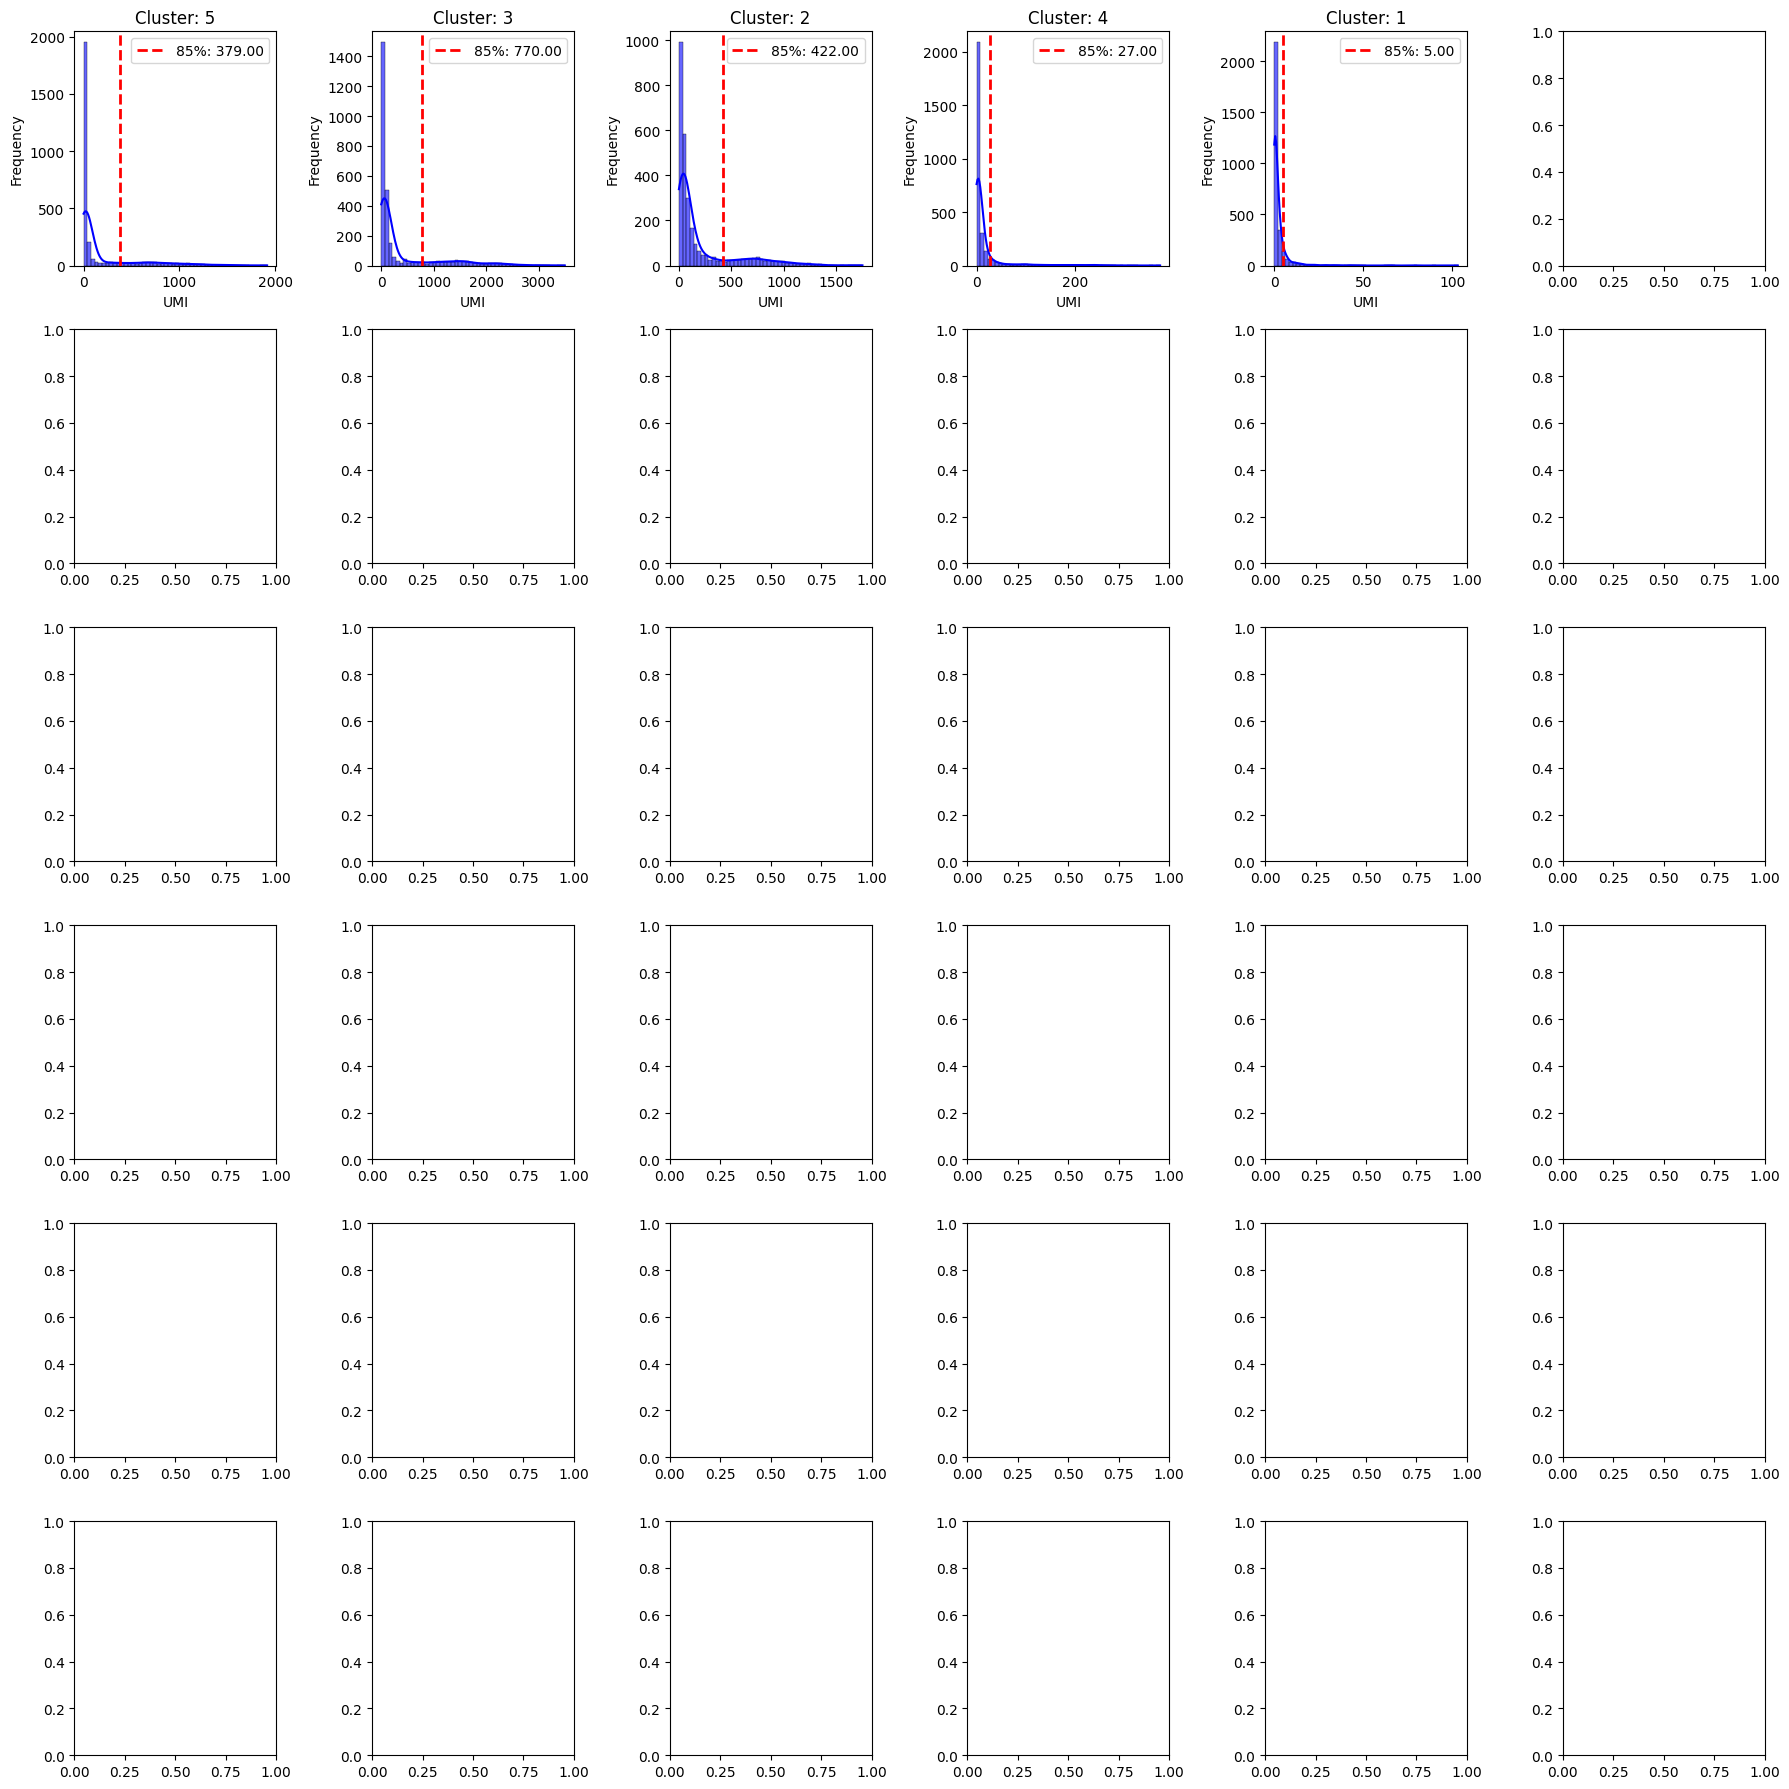

In [13]:
# Plot histograms with percentile threshold lines
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(18, 18))
axes = axes.flatten()

for i, col in enumerate(df_numeric.columns):
    ax = axes[i]
    sns.histplot(df_numeric[col], bins=50, kde=True, color="blue", edgecolor="black", alpha=0.6, ax=ax)
    ax.axvline(thresholds[col], color="red", linestyle="dashed", linewidth=2, label=f"85%: {thresholds[col]:.2f}")
    ax.set_title(f"Cluster: {col}")
    ax.set_xlabel("UMI")
    ax.set_ylabel("Frequency")
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [14]:
# thresholds_df.T

In [15]:
# # UMI Th should be placed directly afther the main distrubution or inbetween the two in case of a bi-modal distribution

# updated_th = [25.0,57.0,422.0,25.0,11.0,25.0,17.0,9.0,34.0,50.0,75.0,50.0,34.0,120.0,440.0,548.0,210.0,250.0]

# keys = list(thresholds.keys())

# for k, v in zip(keys, updated_th):
#     thresholds[k] = v

# thresholds_df = pd.DataFrame.from_dict(thresholds, orient="index", columns=["UMI Th"])

# # Plot histograms with 99th percentile threshold lines
# fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(18, 10))
# axes = axes.flatten()

# for i, col in enumerate(df_numeric.columns):
#     ax = axes[i]
#     sns.histplot(df_numeric[col], bins=30, kde=True, color="blue", edgecolor="black", alpha=0.6, ax=ax)
#     ax.axvline(thresholds[col], color="red", linestyle="dashed", linewidth=2, label=f"Th: {thresholds[col]:.2f}")
#     ax.set_title(f"Cluster: {col}")
#     ax.set_xlabel("UMI")
#     ax.set_ylabel("Frequency")
#     ax.legend()

# # Adjust layout
# plt.tight_layout()
# plt.show()

In [16]:
# Calculate putative cell count per spot 
# by replacing the values less than the percentile threshold with 0, counting medians, and dividing by them
thresholds_broadcasted = thresholds_df.reindex(deconvolution.index).values 

deconvolution_filtered = deconvolution.where(deconvolution >= thresholds_broadcasted, 0)

deconvolution_nonzero = deconvolution_filtered.replace(0, np.nan)

cluster_mins = deconvolution_nonzero.min(axis=1, numeric_only=True)+1

cell_count = np.ceil(deconvolution_nonzero.div(cluster_mins, axis=0))

cell_count = cell_count.fillna(0).astype(int)

cell_count.T.sum()

Cluster
5    1412
3    1345
2    1230
4    1351
1     872
dtype: int64

In [17]:
cells_per_spot = 13 # Set putative meadian cell per spot count
spots = deconvolution.shape[1]

print(f'                       The predicted total cell number is {spots * cells_per_spot}')
print(f'The total cell number observed after the deconvolution is {round(cell_count.T.sum().sum())}')
print(f'                                             The ratio is {(spots * cells_per_spot)/(cell_count.T.sum().sum())}')

                       The predicted total cell number is 37674
The total cell number observed after the deconvolution is 6210
                                             The ratio is 6.066666666666666


In [18]:
# Call Putative cell clusters per spot

# Convert Visium and cell_count to dense format
Visium = Visium.astype(float)
cell_count = cell_count.astype(float)

# Create a new DataFrame for subcells
filtered_columns = [
    f"{spot}_{cluster}" for spot in Visium.columns for cluster in df_clusters.index
    if cell_count.at[cluster, spot] > 0  # Only keep clusters with nonzero putative cell counts
]

# Initialize putative_cell_df with only the required columns
putative_cell_df = pd.DataFrame(0, index=Visium.index, columns=filtered_columns, dtype=float)

# Populate putative_cell_df with gene expression values
for spot in Visium.columns:
    for cluster, genes in df_clusters["Genes"].items():
        if cell_count.at[cluster, spot] > 0:  # Check if putative cell count is above 0
            subspot_name = f"{spot}_{cluster}"  
            putative_cell_df[subspot_name] = Visium[spot]  # Copy UMI cell values
            putative_cell_df.loc[~putative_cell_df.index.isin(genes), subspot_name] = 0  # Set non-cluster genes to 0

putative_cell_per_spot = putative_cell_df.astype(int)

putative_cell_per_spot

,AACCAGAATCAGACGT-1_1,AACCATCGGAAGCGAC-1_1,AACCTGACAGTGCCGC-1_5,AACCTGACAGTGCCGC-1_3,AACCTGACAGTGCCGC-1_2,AACCTGACAGTGCCGC-1_1,AACGAAGCGTGGAAGT-1_5,AACGAAGCGTGGAAGT-1_3,AACGAAGCGTGGAAGT-1_2,AACTATGCTGCATTCG-1_5,...,TGTTCATAGTATGACG-1_4,TGTTCATAGTATGACG-1_1,TGTTGGAACGAGGTCA-1_5,TGTTGGAACGAGGTCA-1_3,TGTTGGAACGAGGTCA-1_2,TGTTGGCCAGACCTAC-1_5,TGTTGGCCAGACCTAC-1_3,TGTTGGCCAGACCTAC-1_2,TGTTGGCCAGACCTAC-1_4,TGTTGGCCAGACCTAC-1_1
Gene,,,,,,,,,,,,,,,,,,,,,
Lmbrd1,0,0,3,0,0,0,0,0,0,2,...,0,0,2,0,0,6,0,0,0,0
Zfp451,0,0,0,4,0,0,0,1,0,0,...,0,0,0,1,0,0,2,0,0,0
Cnnm3,0,0,0,2,0,0,0,4,0,0,...,0,0,0,4,0,0,6,0,0,0
Pou3f3,0,0,2,0,0,0,3,0,0,4,...,0,0,3,0,0,2,0,0,0,0
Klf7,0,0,1,0,0,0,0,0,0,3,...,0,0,2,0,0,5,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mecp2,0,0,0,0,0,0,1,0,0,3,...,0,0,0,0,0,1,0,0,0,0
Fam50a,0,0,0,1,0,0,0,2,0,0,...,0,0,0,2,0,0,6,0,0,0
Cstf2,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Call Putative cells per spot

cell_count.index = cell_count.index.astype(str)
cell_count.columns = cell_count.columns.astype(str)

# Initialize a new DataFrame for putative_cells
putative_cell_data = {}

# Iterate through each subcell in putative_cell_per_spot
for subcell in putative_cell_per_spot.columns:
    cell, cluster = map(str, subcell.split("_"))  # Ensure names are strings
    
    # Check if cluster and cell exist in cell_count before accessing
    if cluster in cell_count.index and cell in cell_count.columns:
        putative_count = cell_count.at[cluster, cell]
    else:
        print(f"Warning: Skipping {subcell} - No match found in cell_count")
        continue  # Skip this subcell if the match isn't found

    if putative_count > 0:  # Only process if there are putative_cells
        putative_count = int(np.ceil(putative_count))  # Ensure it's an integer
        split_values = np.ceil(putative_cell_per_spot[subcell] / putative_count).astype(int)
    
        # Create new columns for each putative_cell
        for i in range(1, putative_count + 1):  # Now `putative_count` is an integer
            putative_cell_name = f"{subcell}_{i}"
            putative_cell_data[putative_cell_name] = split_values

# Convert to DataFrame
putative_cell_df = pd.DataFrame(putative_cell_data)

putative_cell_df = putative_cell_df.loc[:, putative_cell_df.sum(axis=0) != 0]

putative_cell_df = putative_cell_df.astype(str)

putative_cell_df = putative_cell_df[~putative_cell_df.index.duplicated(keep="first")]

putative_cell_df

,AACCAGAATCAGACGT-1_1_1,AACCAGAATCAGACGT-1_1_2,AACCAGAATCAGACGT-1_1_3,AACCAGAATCAGACGT-1_1_4,AACCAGAATCAGACGT-1_1_5,AACCAGAATCAGACGT-1_1_6,AACCATCGGAAGCGAC-1_1_1,AACCTGACAGTGCCGC-1_5_1,AACCTGACAGTGCCGC-1_5_2,AACCTGACAGTGCCGC-1_5_3,...,TGTTGGCCAGACCTAC-1_2_3,TGTTGGCCAGACCTAC-1_4_1,TGTTGGCCAGACCTAC-1_4_2,TGTTGGCCAGACCTAC-1_4_3,TGTTGGCCAGACCTAC-1_4_4,TGTTGGCCAGACCTAC-1_4_5,TGTTGGCCAGACCTAC-1_4_6,TGTTGGCCAGACCTAC-1_1_1,TGTTGGCCAGACCTAC-1_1_2,TGTTGGCCAGACCTAC-1_1_3
Gene,,,,,,,,,,,,,,,,,,,,,
Lmbrd1,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Zfp451,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cnnm3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Pou3f3,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Klf7,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mecp2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Fam50a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cstf2,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [20]:
import json
import math

# Load the JSON file
with open("./spatial/scalefactors_json.json", "r") as file:
    scalefactors = json.load(file)

# Extract and round up the spot radius
SPOT_RADIUS = math.ceil(scalefactors["spot_diameter_fullres"])
SPOT_RADIUS

15

In [21]:
# Randomly allocate Putative cells within their spot

# Spot radius and min distance
MIN_DISTANCE = SPOT_RADIUS/15*6 # Minimum pixel separation between putative_cells

# Initialize spatial coordinates dictionary
putative_cell_spatial = {}

# Iterate over putative_cells and assign random spatial positions
for putative_cell in putative_cell_df.columns:
    # Extract the correct `cell_cluster` name
    cell_cluster = putative_cell.split("_", 1)[0]  # Keep only barcode (remove extra numbers)

    if cell_cluster in tissue_positions_data.index:
        center_x = tissue_positions_data.at[cell_cluster, "pxl_row_in_fullres"]
        center_y = tissue_positions_data.at[cell_cluster, "pxl_col_in_fullres"]
    else:
        print(f"Warning: {cell_cluster} not found in tissue_positions_data")
        continue  # Skip if no spatial data

    # Generate unique positions within spot radius
    putative_cell_positions = []
    attempts = 0
    
    while len(putative_cell_positions) < 1:  # Only need one valid position per putative_cell
        # Randomly place within the spot's circular area
        rand_radius = np.random.uniform(0, SPOT_RADIUS)
        rand_angle = np.random.uniform(0, 2 * np.pi)
        new_x = center_x + rand_radius * np.cos(rand_angle)
        new_y = center_y + rand_radius * np.sin(rand_angle)
        
        # Ensure at least MIN_DISTANCE separation from other putative_cells
        if all(np.sqrt((new_x - x)**2 + (new_y - y)**2) >= MIN_DISTANCE for x, y in putative_cell_positions):
            putative_cell_positions.append((new_x, new_y))
            putative_cell_spatial[putative_cell] = (new_x, new_y)
        else:
            attempts += 1
            if attempts > 100:  # Prevent infinite loops
                print(f"Warning: Could not place {putative_cell} with required spacing")
                break

# Convert to mimic the Vizgen format
putative_cell_spatial_df = pd.DataFrame.from_dict(putative_cell_spatial, orient="index", columns=["center_x", "center_y"])
putative_cell_spatial_df['z'] = 0
putative_cell_spatial_df['fov'] = 0

# Export data in Vizgen format
putative_cell_df.astype(int).T.to_csv('cell_by_gene.csv') 
putative_cell_spatial_df.to_csv('cell_metadata.csv')

putative_cell_spatial_df

,center_x,center_y,z,fov
AACCAGAATCAGACGT-1_1_1,1879.930734,1068.782868,0,0
AACCAGAATCAGACGT-1_1_2,1873.435592,1075.963242,0,0
AACCAGAATCAGACGT-1_1_3,1874.674355,1071.397467,0,0
AACCAGAATCAGACGT-1_1_4,1870.349952,1077.416054,0,0
AACCAGAATCAGACGT-1_1_5,1867.757699,1085.169954,0,0
...,...,...,...,...
TGTTGGCCAGACCTAC-1_4_5,1686.262451,752.337121,0,0
TGTTGGCCAGACCTAC-1_4_6,1680.574711,764.632357,0,0
TGTTGGCCAGACCTAC-1_1_1,1697.141194,756.926994,0,0
TGTTGGCCAGACCTAC-1_1_2,1686.173859,755.226424,0,0


In [22]:
# Export Cluster numbers
cluster_df = putative_cell_spatial_df.index.str.extract(r'-1_(\d+)_')
cluster_df = cluster_df.rename(columns={0: 'Cluster'})
cluster_df.index = putative_cell_spatial_df.index
cluster_df.to_csv('cluster_info.csv')
cluster_df.head()
b = time.time()

In [23]:
print(f'It took {(b - a)/60} minutes')

It took 0.16612776517868041 minutes
